This notebook loads disp rate maps and residual stds for each time period, plots them, and masks them with threshold value. 

This notebook was copied and edited on 5-10-23.

***

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib  widget 

Use filt? Or unfilt?

In [2]:
# choose 'filt' or 'unfilt'
key1 = 'unfilt'
# choose one: 'avg_val' or 'ref_box' or 'ref_pix'
key2 = 'ref_pix'

Load dates of SLCs/igrams and set directories.

In [3]:
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
dx = 3000
dy = 750

# larger cropped area with western mountains 
dx = 4000
dy = 1100

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
unwr_full_res = np.ndarray((numIgrams,dy,dx),dtype='float')

Define the intervals.

In [4]:
start_indices = [0,47,108,147,0,0,107]
end_indices = [46,107,146,numIgrams,88,numIgrams,153]
num_intervals = len(end_indices)
# the last one I just added (4-12-23) as a totally dry period

for i in range(num_intervals):
    print('interval '+str(i)+': '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
print(str(num_intervals)+' intervals.')

interval 0: 20170510-20181125
interval 1: 20181207-20200412
interval 2: 20200418-20201208
interval 3: 20201214-20220108
interval 4: 20170510-20191220
interval 5: 20170510-20220108
interval 6: 20200412-20210119
7 intervals.


Read in disp rate maps and residual std maps.

In [17]:
# read in full res disp rate files
# loadDir = '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_for_intervals/'
loadDir = '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_with_western_mtns/'

j = 6
fileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'.r4'
errorFileName = 'interval_'+str(j)+'_'+key1+'_weighted_ref_to_'+key2+'_residual_std.r4'

saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/11_unwrapped_igrams/disp_rate_maps_with_western_mtns/'
disp_rates = np.ndarray((dy,dx),dtype='float') 
disp_rates_errors = np.ndarray((dy,dx),dtype='float') 

f1 = gdal.Open(saveDir+fileName, gdal.GA_ReadOnly)
disp_rates = f1.ReadAsArray()
f1 = None

f1 = gdal.Open(saveDir+errorFileName, gdal.GA_ReadOnly)
disp_rates_errors = f1.ReadAsArray()
f1 = None

print('interval '+str(j)+' disp rate map + errors loaded.')

interval 6 disp rate map + errors loaded.


Plot the disp rate map and the map of errors.

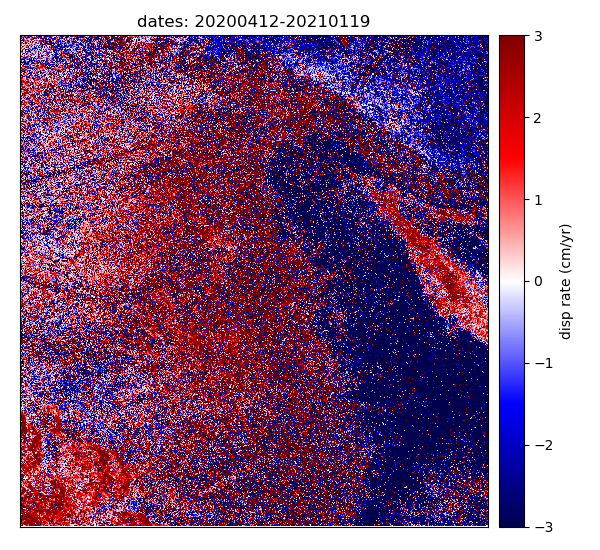

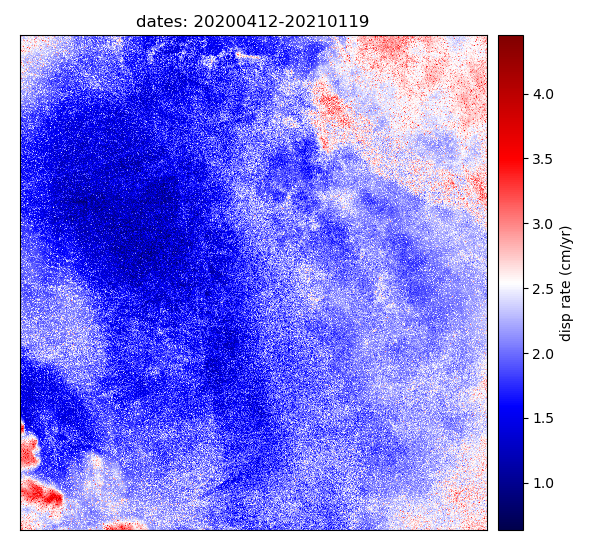

In [18]:
i = 6 # for 0-3 I used vmin=-5.0,vmax=5.0, but for 4-5 I used vmin=-3.0, vmax=3.0
#print('interval '+str(i)+', dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates, aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()

plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates_errors, aspect='auto',\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]]))
plt.show()

Now mask based on avg coherence and std of coherence.

In [19]:
loadDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'

file_name = 'coh_avg.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
coh_avg = f1.ReadAsArray()
f1 = None
print('Avg coh values map loaded.')

file_name = 'coh_std.r4' 
f1 = gdal.Open(loadDir+file_name, gdal.GA_ReadOnly)
coh_std = f1.ReadAsArray()
f1 = None
print('Std of coh map loaded.')

Avg coh values map loaded.
Std of coh map loaded.


Mask based on avg coh values.

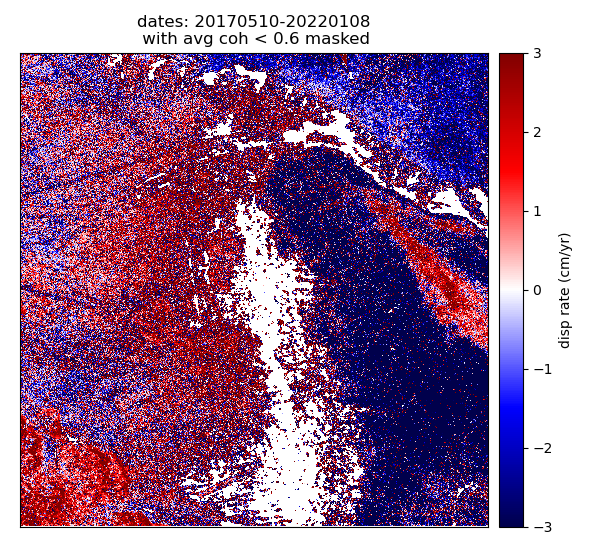

In [20]:
# threshold value- does this cut out any pixels?
coh_th= 0.6
disp_rates_masked = np.ma.masked_where(coh_avg<coh_th,disp_rates)

i = 5 
plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates_masked, aspect='auto', vmin=-3.0,vmax=3.0,\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]])+'\n with avg coh < '+str(coh_th)+' masked')
plt.show()

Now mask based on RMSE of fit (error).

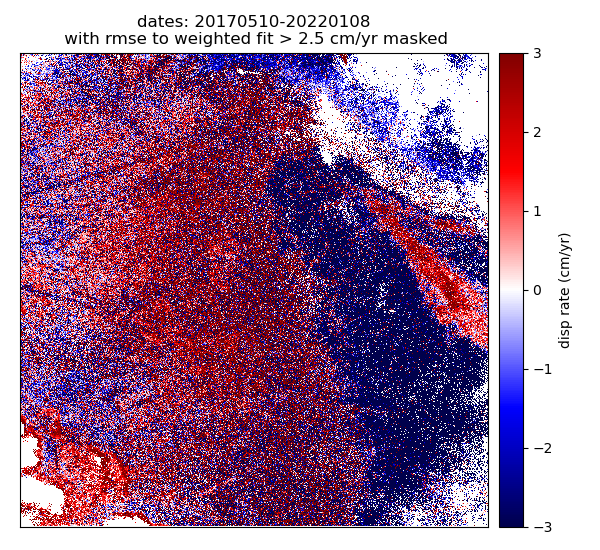

In [9]:
# threshold value- does this cut out any pixels?
rmse_th= 2.5
disp_rates_masked2 = np.ma.masked_where(disp_rates_errors>rmse_th,disp_rates)

i = 5 
plt.figure(figsize=(6,5.5),tight_layout=True)
plt.imshow(disp_rates_masked2, aspect='auto',vmin=-3.0,vmax=3.0,\
            interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.set_cmap('seismic')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.xticks([]); plt.yticks([])
plt.title('dates: '+str(dates[start_indices[i]])+'-'+str(dates[end_indices[i]])+'\n with rmse to weighted fit > '+str(rmse_th)+' cm/yr masked')
plt.show()